In [34]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime

pd.set_option("display.max_colwidth", None)

In [73]:
# Load data from github
!wget https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/US_category_id.json
!wget https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/USvideos.csv

--2024-06-05 05:01:51--  https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/US_category_id.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8496 (8.3K) [text/plain]
Saving to: ‘US_category_id.json.1’

US_category_id.json 100%[===================>]   8.30K  --.-KB/s    in 0s      

2024-06-05 05:01:51 (64.4 MB/s) - ‘US_category_id.json.1’ saved [8496/8496]

--2024-06-05 05:01:51--  https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/USvideos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP re

In [74]:
# Read data into dataframe
youtube_df = pd.read_csv('USvideos.csv')
youtube_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with John Oliver (HBO),LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week tonight donald trump""|""john oliver trump""|""donald trump""",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John Oliver discusses what we've learned so far and enlists our catheter cowboy to teach Donald Trump what he hasn't.\n\nConnect with Last Week Tonight online...\n\nSubscribe to the Last Week Tonight YouTube channel for more almost news as it almost happens: www.youtube.com/user/LastWeekTonight\n\nFind Last Week Tonight on Facebook like your mom would: http://Facebook.com/LastWeekTonight\n\nFollow us on Twitter for news about jokes and jokes about news: http://Twitter.com/LastWeekTonight\n\nVisit our official site for all that other stuff at once: http://www.hbo.com/lastweektonight"
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Lele Pons",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""|""racist""|""superman""|""love""|""rudy mancuso poo bear black white official music video""|""iphone x by pineapple""|""lelepons""|""hannahstocking""|""rudymancuso""|""inanna""|""anwar""|""sarkis""|""shots""|""shotsstudios""|""alesso""|""anitta""|""brazil""|""Getting My Driver's License | Lele Pons""",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► https://www.youtube.com/channel/UC5jkXpfnBhlDjqh0ir5FsIQ?sub_confirmation=1\n\nTHANKS FOR WATCHING! LIKE & SUBSCRIBE FOR MORE VIDEOS!\n-----------------------------------------------------------\nFIND ME ON: \nInstagram | http://instagram.com/rudymancuso\nTwitter | http://twitter.com/rudymancuso\nFacebook | http://facebook.com/rudymancuso\n\nCAST: \nRudy Mancuso | http://youtube.com/c/rudymancuso\nLele Pons | http://youtube.com/c/lelepons\nKing Bach | https://youtube.com/user/BachelorsPadTv\n\nVideo Effects: \nCaleb Natale | https://instagram.com/calebnatale\n\nPA:\nPaulina Gregory\n\n\nShots Studios Channels:\nAle

In [75]:
# Extract video category labels and ids from auxillary JSON file
with open("US_category_id.json", "r") as f:
    data = json.load(f)

# Create a dictionary mapping ids to lablels
categories = {}
for item in data['items']:
    id = int(item['id'])
    category = item['snippet']['title']
    categories[id] = category

print(categories)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


In [76]:
# Add category labels for each video
youtube_df['category_label'] = youtube_df['category_id'].apply(lambda x: categories[x])
youtube_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_label
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with John Oliver (HBO),LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week tonight donald trump""|""john oliver trump""|""donald trump""",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John Oliver discusses what we've learned so far and enlists our catheter cowboy to teach Donald Trump what he hasn't.\n\nConnect with Last Week Tonight online...\n\nSubscribe to the Last Week Tonight YouTube channel for more almost news as it almost happens: www.youtube.com/user/LastWeekTonight\n\nFind Last Week Tonight on Facebook like your mom would: http://Facebook.com/LastWeekTonight\n\nFollow us on Twitter for news about jokes and jokes about news: http://Twitter.com/LastWeekTonight\n\nVisit our official site for all that other stuff at once: http://www.hbo.com/lastweektonight",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Lele Pons",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""|""racist""|""superman""|""love""|""rudy mancuso poo bear black white official music video""|""iphone x by pineapple""|""lelepons""|""hannahstocking""|""rudymancuso""|""inanna""|""anwar""|""sarkis""|""shots""|""shotsstudios""|""alesso""|""anitta""|""brazil""|""Getting My Driver's License | Lele Pons""",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► https://www.youtube.com/channel/UC5jkXpfnBhlDjqh0ir5FsIQ?sub_confirmation=1\n\nTHANKS FOR WATCHING! LIKE & SUBSCRIBE FOR MORE VIDEOS!\n-----------------------------------------------------------\nFIND ME ON: \nInstagram | http://instagram.com/rudymancuso\nTwitter | http://twitter.com/rudymancuso\nFacebook | http://facebook.com/rudymancuso\n\nCAST: \nRudy Mancuso | http://youtube.com/c/rudymancuso\nLele Pons | http://youtube.com/c/lelepons\nKing Bach | https://youtube.com/user/BachelorsPadTv\n\nVideo Effects: \nCaleb Natale | https://instagram.com/calebnatale\n\nPA:\nPauli

In [77]:
# View how many videos are in each category
youtube_df['category_label'].value_counts()

category_label
Entertainment            9964
Music                    6472
Howto & Style            4146
Comedy                   3457
People & Blogs           3210
News & Politics          2487
Science & Technology     2401
Film & Animation         2345
Sports                   2174
Education                1656
Pets & Animals            920
Gaming                    817
Travel & Events           402
Autos & Vehicles          384
Nonprofits & Activism      57
Shows                      57
Name: count, dtype: int64

In [78]:
# View trending date range
print(f"{youtube_df['trending_date'].min()} - {youtube_df['trending_date'].max()}")

17.01.12 - 18.31.05


In [79]:
# Drop columns that don't provide useful information
youtube_df.drop(columns=['video_id', 'trending_date', 'thumbnail_link'], inplace=True)
youtube_df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category_label
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.,People & Blogs
1,The Trump Presidency: Last Week Tonight with John Oliver (HBO),LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week tonight donald trump""|""john oliver trump""|""donald trump""",2418783,97185,6146,12703,False,False,False,"One year after the presidential election, John Oliver discusses what we've learned so far and enlists our catheter cowboy to teach Donald Trump what he hasn't.\n\nConnect with Last Week Tonight online...\n\nSubscribe to the Last Week Tonight YouTube channel for more almost news as it almost happens: www.youtube.com/user/LastWeekTonight\n\nFind Last Week Tonight on Facebook like your mom would: http://Facebook.com/LastWeekTonight\n\nFollow us on Twitter for news about jokes and jokes about news: http://Twitter.com/LastWeekTonight\n\nVisit our official site for all that other stuff at once: http://www.hbo.com/lastweektonight",Entertainment
2,"Racist Superman | Rudy Mancuso, King Bach & Lele Pons",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""|""racist""|""superman""|""love""|""rudy mancuso poo bear black white official music video""|""iphone x by pineapple""|""lelepons""|""hannahstocking""|""rudymancuso""|""inanna""|""anwar""|""sarkis""|""shots""|""shotsstudios""|""alesso""|""anitta""|""brazil""|""Getting My Driver's License | Lele Pons""",3191434,146033,5339,8181,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► https://www.youtube.com/channel/UC5jkXpfnBhlDjqh0ir5FsIQ?sub_confirmation=1\n\nTHANKS FOR WATCHING! LIKE & SUBSCRIBE FOR MORE VIDEOS!\n-----------------------------------------------------------\nFIND ME ON: \nInstagram | http://instagram.com/rudymancuso\nTwitter | http://twitter.com/rudymancuso\nFacebook | http://facebook.com/rudymancuso\n\nCAST: \nRudy Mancuso | http://youtube.com/c/rudymancuso\nLele Pons | http://youtube.com/c/lelepons\nKing Bach | https://youtube.com/user/BachelorsPadTv\n\nVideo Effects: \nCaleb Natale | https://instagram.com/calebnatale\n\nPA:\nPaulina Gregory\n\n\nShots Studios Channels:\nAlesso | https://youtube.com/c/alesso\nAnitta | http://youtube.com/c/anitta\nAnwar Jibawi | http://youtube.com/c/anwar\nAwkward Puppets | http://youtube.com/c/awkwardpuppets\nHannah Stocking | http://y

In [80]:
# Extract hour, time of day, and day of week
# Morning 5 am to 12 pm (noon)
# Afternoon 12 pm to 5 pm
# Evening 5 pm to 9 pm
# Night 9 pm to 4 am
def get_time_day(row):
  timestamp = datetime.fromisoformat(row.replace("Z", "+00:00"))
  day = timestamp.weekday()
  hour = timestamp.hour
  period = 0 if hour >= 5 and hour < 12 else \
   (1 if hour >= 12 and hour < 17 else (2 if hour >= 17 and hour < 21 else 3))
  return pd.Series([timestamp, hour, period, day], index=['publish_time', 'hour', 'time_of_day', 'day_of_week'])

youtube_df[['publish_time', 'hour', 'time_of_day', 'day_of_week']] = youtube_df['publish_time'].apply(get_time_day)
youtube_df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category_label,hour,time_of_day,day_of_week
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.,People & Blogs,17,2,0
1,The Trump Presidency: Last Week Tonight with John Oliver (HBO),LastWeekTonight,24,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week tonight donald trump""|""john oliver trump""|""donald trump""",2418783,97185,6146,12703,False,False,False,"One year after the presidential election, John Oliver discusses what we've learned so far and enlists our catheter cowboy to teach Donald Trump what he hasn't.\n\nConnect with Last Week Tonight online...\n\nSubscribe to the Last Week Tonight YouTube channel for more almost news as it almost happens: www.youtube.com/user/LastWeekTonight\n\nFind Last Week Tonight on Facebook like your mom would: http://Facebook.com/LastWeekTonight\n\nFollow us on Twitter for news about jokes and jokes about news: http://Twitter.com/LastWeekTonight\n\nVisit our official site for all that other stuff at once: http://www.hbo.com/lastweektonight",Entertainment,7,0,0
2,"Racist Superman | Rudy Mancuso, King Bach & Lele Pons",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""|""racist""|""superman""|""love""|""rudy mancuso poo bear black white official music video""|""iphone x by pineapple""|""lelepons""|""hannahstocking""|""rudymancuso""|""inanna""|""anwar""|""sarkis""|""shots""|""shotsstudios""|""alesso""|""anitta""|""brazil""|""Getting My Driver's License | Lele Pons""",3191434,146033,5339,8181,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► https://www.youtube.com/channel/UC5jkXpfnBhlDjqh0ir5FsIQ?sub_confirmation=1\n\nTHANKS FOR WATCHING! LIKE & SUBSCRIBE FOR MORE VIDEOS!\n-----------------------------------------------------------\nFIND ME ON: \nInstagram | http://instagram.com/rudymancuso\nTwitter | http://twitter.com/rudymancuso\nFacebook | http://facebook.com/rudymancuso\n\nCAST: \nRudy Mancuso | http://youtube.com/c/rudymancuso\nLele Pons | http://youtube.com/c/lelepons\nKing Bach | https://youtube.com/user/BachelorsPadTv\n\nVideo Effects: \nCaleb Natale | https://instagram.com/calebnatale\n\nPA:\nPaulina Gregory\n\n\nShots Studios Channels:\nAlesso | https://youtube.com/c/alesso\nAnitta | http://youtube.com/c/anitta\nAnwar Jibawi | http://youtube.com/c/anwar\nAwkward Puppets | http://youtube.com

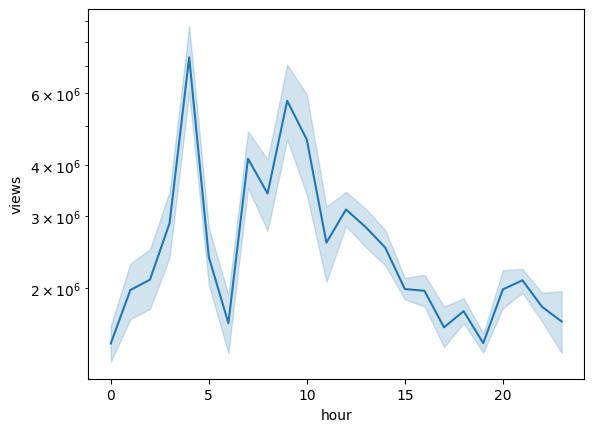

In [81]:
ax = sns.lineplot(data=youtube_df, x='hour', y='views')
ax.set_yscale('log')


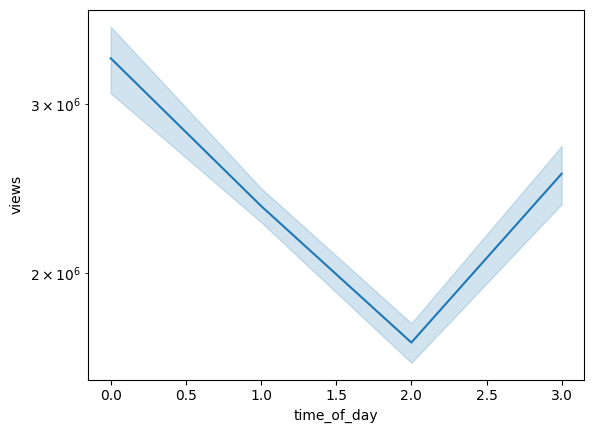

In [82]:
ax = sns.lineplot(data=youtube_df, x='time_of_day', y='views')
ax.set_yscale('log')

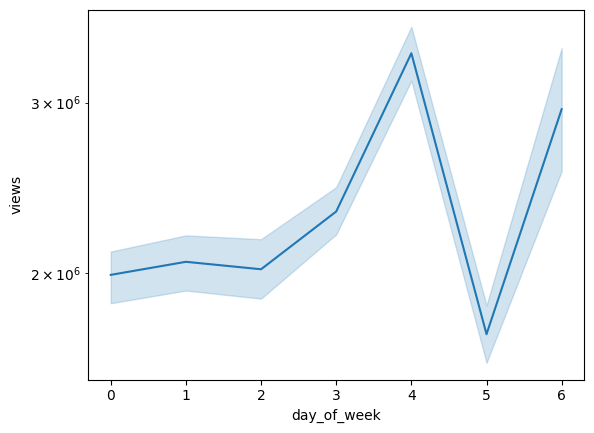

In [83]:
ax = sns.lineplot(data=youtube_df, x='day_of_week', y='views')
ax.set_yscale('log')

In [84]:
# Encode time variables using angular distance